In [99]:
from Dataload import dataload
import torch.nn.functional as F

import torch
import torch.nn as nn
from torchsummary import summary
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from torchvision import  utils

from src import detect_faces, show_bboxes
from PIL import Image
import numpy as np
from module import video_model
from constant import EMOTIPATH
import os
import pandas as pd
import time
from tqdm.notebook import tqdm
import cv2
from torchvision import transforms


In [ ]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")


dense_pre=densenet.densenet121(pretrained=True)

In [ ]:
output=frame_model(img_frames.unsqueeze(0))

In [ ]:
output.shape

In [ ]:
output

In [ ]:

#model=video_model.Video_Feature(joint=False,grayscale=False,classfication=True,frame=10)


In [100]:
Train_label=os.path.join(EMOTIPATH,"Train_labels.txt")
Train_video=os.path.join(EMOTIPATH,"Train")
frame_num=24
train_data=Raw_Data(Train_label,base_path_v=Train_video)


In [98]:
class Raw_Data():
    def __init__(self,csv_file,base_path_v=None,):
        
        self.max_frame_num=24
        self._table = pd.read_csv(csv_file,delimiter=' ')

        self._base_path_v=base_path_v
  

            

        self.transform=transforms.Compose([
                     transforms.Resize((256,256)),
                     transforms.ToTensor(),   
                     transforms.Normalize((0.5,0.5,0.5 ), (0.5, 0.5,0.5))])
    def __len__(self):
        return len(self._table)

    def __getitem__(self, idx):
        folder_name = os.path.join(self._base_path_v,self._table.Vid_name[idx])
        frame_list=os.listdir(folder_name)


        return folder_name,frame_list

In [102]:
train_data[566]

('../../../hdd/Dataset/Dataset/Train/57_13',
 ['000011.png',
  '000008.png',
  '000004.png',
  '000003.png',
  '000016.png',
  '000005.png',
  '000002.png',
  '000017.png',
  '000014.png',
  '000010.png',
  '000001.png',
  '000021.png',
  '000013.png',
  '000007.png',
  '000019.png',
  '000009.png',
  '000022.png',
  '000006.png',
  '000020.png',
  '000015.png',
  '000012.png',
  '000024.png',
  '000018.png',
  '000023.png'])

In [ ]:
from operator import itemgetter, attrgetter

In [ ]:
def extract_best(num_frame,data):

for index,(base_path,imglist) in enumerate(train_data):
    confidence_score_list=[]
    for img_frame in imglist:
        
        img=Image.open(os.path.join(base_path,img_frame))
        total_confidence_score=sum(detect_faces(img)[0][0:5,-1])
        confidence_score_list.append((total_confidence_score,img_frame))
    confidence_score_list=sorted(confidence_score_list, key=itemgetter(0),reverse=True)
    sorted(confidence_score_list[0:num_frame]
    break


In [ ]:
confidence_score_list[0:5]

In [ ]:
confidence_score_list=sorted(confidence_score_list, key=itemgetter(0),reverse=True)

In [ ]:
confidence_score_list[0:5]

In [ ]:
sorted(confidence_score_list[0:5],key=itemgetter(0))

In [ ]:
img=Image.open(os.path.join(train_data[0][0],train_data[0][1][1]))

In [ ]:
img

In [ ]:
confidence_score=sum(detect_faces(img)[0][0:5,-1])

In [ ]:
sum(confidence_score)

In [ ]:
faces[0][0:5,-1]

In [68]:
    
class cv_data(Dataset):
    def __init__(self,csv_file,sub_csv_file=None,
                 base_path_v=None,base_path_a=None,frame_num=16,strict_name=True,name_format=9,embedding=False):
        
        self.max_frame_num=24
        self._table = pd.read_csv(csv_file,delimiter=' ')
        if sub_csv_file is None:
            self._table_embedding=None
        else:
            self._table_embedding=pd.read_csv(sub_csv_file)
        self.frame_num = frame_num
        self._base_path_v=base_path_v
        self._base_path_a=base_path_a
        self.embedding=embedding
        if strict_name:
            self.name_format=name_format
            

        self.transform=transforms.Compose([
                     transforms.ToTensor(),   
                     transforms.Normalize((0.5,0.5,0.5 ), (0.5, 0.5,0.5))])
    def __len__(self):
        return len(self._table)

    def __getitem__(self, idx):
        folder_name = os.path.join(self._base_path_v,self._table.Vid_name[idx])
        first=True
        audio_img=np.zeros((1,1))
        labels = torch.from_numpy(np.array(self._table.Label[idx]))-1
            
        if self._table_embedding is not None:
            temp_frame_embedding=torch.from_numpy(np.array(self._table_embedding.Embedding[idx].split(),dtype=float)).reshape((self.max_frame_num,-1))
            frame_data=torch.empty(size=(self.frame_num,1000),dtype=torch.double)
            if self.frame_num<25:
                index=np.linspace(0,23,self.frame_num,dtype=int)
 
                for i,copy in enumerate(index):
                    frame_data[i]=temp_frame_embedding[copy]
            return (frame_data,audio_img,labels)
    

            
        frame_raw_list=os.listdir(folder_name)
        frame_len=len(frame_raw_list)

        frame_raw_list=sorted(frame_raw_list)

        frame_list=[]
        if frame_len<self.frame_num:
            for index_0 in range(frame_len):
                frame_path=os.path.join(folder_name,frame_raw_list[index_0])
                
                tempimg=cv2.imread(frame_path,cv2.IMREAD_COLOR)  
                tempimg=cv2.resize(tempimg, (256,256), interpolation = cv2.INTER_AREA)
               # frame_class=frame(tempimg,frame_path)
                frame_list.append(self.transform(tempimg))
        else:    
            frame_index=(np.linspace(0,frame_len-1,self.frame_num,dtype=int))

            for index_2 in frame_index:
                frame_path=os.path.join(folder_name,frame_raw_list[index_2])
                tempimg=cv2.imread(frame_path,cv2.IMREAD_COLOR)
                tempimg=cv2.resize(tempimg, (256,256), interpolation = cv2.INTER_AREA)

                #frame_class=frame(tempimg,frame_path)
                frame_list.append(self.transform(tempimg))
        frame_data=torch.stack(frame_list,dim=0)
        return (frame_data,audio_img,labels)

In [94]:
    
class pil_data(Dataset):
    def __init__(self,csv_file,sub_csv_file=None,
                 base_path_v=None,base_path_a=None,frame_num=16,strict_name=True,name_format=9,embedding=False):
        
        self.max_frame_num=24
        self._table = pd.read_csv(csv_file,delimiter=' ')
        if sub_csv_file is None:
            self._table_embedding=None
        else:
            self._table_embedding=pd.read_csv(sub_csv_file)
        self.frame_num = frame_num
        self._base_path_v=base_path_v
        self._base_path_a=base_path_a
        self.embedding=embedding
        if strict_name:
            self.name_format=name_format
            

        self.transform=transforms.Compose([
                     transforms.Resize((256,256)),
                     transforms.ToTensor(),   
                     transforms.Normalize((0.5,0.5,0.5 ), (0.5, 0.5,0.5))])
    def __len__(self):
        return len(self._table)

    def __getitem__(self, idx):
        folder_name = os.path.join(self._base_path_v,self._table.Vid_name[idx])
        first=True
        audio_img=np.zeros((1,1))
        labels = torch.from_numpy(np.array(self._table.Label[idx]))-1
            
        if self._table_embedding is not None:
            temp_frame_embedding=torch.from_numpy(np.array(self._table_embedding.Embedding[idx].split(),dtype=float)).reshape((self.max_frame_num,-1))
            frame_data=torch.empty(size=(self.frame_num,1000),dtype=torch.double)
            if self.frame_num<25:
                index=np.linspace(0,23,self.frame_num,dtype=int)
 
                for i,copy in enumerate(index):
                    frame_data[i]=temp_frame_embedding[copy]
            return (frame_data,audio_img,labels)
    
        
            
        frame_raw_list=os.listdir(folder_name)
        frame_len=len(frame_raw_list)

        frame_raw_list=sorted(frame_raw_list)

        frame_list=[]
        if frame_len<self.frame_num:
            for index_0 in range(frame_len):
                frame_path=os.path.join(folder_name,frame_raw_list[index_0])
                
                tempimg=Image.open(frame_path)       
               # frame_class=frame(tempimg,frame_path)
                frame_list.append(self.transform(tempimg))
        else:    
            frame_index=(np.linspace(0,frame_len-1,self.frame_num,dtype=int))

            for index_2 in frame_index:
                frame_path=os.path.join(folder_name,frame_raw_list[index_2])
                tempimg=Image.open(frame_path)
                #frame_class=frame(tempimg,frame_path)
                frame_list.append(self.transform(tempimg))
        frame_data=torch.stack(frame_list,dim=0)
        return (frame_data,audio_img,labels)

In [95]:
Train_label=os.path.join(EMOTIPATH,"Train_labels.txt")
Train_video=os.path.join(EMOTIPATH,"Train")
Val_labels=os.path.join(EMOTIPATH,"Val_labels.txt")
Val_video=os.path.join(EMOTIPATH,"Val")
train_data_pil=pil_data(Train_label,base_path_v=Train_video,frame_num=24)
train_dataloader_pil = DataLoader(train_data_pil, batch_size=24
                       , num_workers=0,shuffle=False)                    
                    

In [96]:
train_data_cv=cv_data(Train_label,base_path_v=Train_video,frame_num=24)
train_dataloader_cv = DataLoader(train_data_cv, batch_size=24
                       , num_workers=0,shuffle=False)       

In [97]:
start=time.time()
for i in enumerate(train_dataloader_pil):
    break

end=time.time()
print(end-start)

3.520815849304199


In [80]:
start=time.time()
for i in enumerate(train_dataloader_cv):
    break

end=time.time()
print(end-start)

3.878101348876953


In [227]:
class Frame_Face_Data(Dataset):
    def __init__(self,csv_file,sub_csv_file=None,base_path_v=None):
        
        self.max_frame_num=5
        self._table = pd.read_csv(csv_file,delimiter=' ')
        self._table_embedding=None
        self.transform=transforms.Compose([
                 #    transforms.Resize((256,256)),
                     transforms.ToTensor(),   
                    transforms.Normalize((0.5,0.5,0.5 ), (0.5, 0.5,0.5))
        ])
        self.endPad=self.transform(Image.new(mode='RGB', size=(64,64), color=0))
        self._base_path_v=base_path_v
        
    def __len__(self):
        return len(self._table)
    def _stacking_face(self,face_num,faces):

        face_v=torch.zeros((face_num,3,64,64))
        for i in range(face_num):
            face_v[i]=faces[:,:,i*64:i*64+64]
        return face_v

    def __getitem__(self, idx):
        folder_name = os.path.join(self._base_path_v,self._table.Vid_name[idx])

        labels = torch.from_numpy(np.array(self._table.Label[idx]))-1
            
        if self._table_embedding is not None:
            temp_frame_embedding=torch.from_numpy(np.array(self._table_embedding.Embedding[idx].split(),dtype=float)).reshape((self.max_frame_num,-1))
            frame_data=torch.empty(size=(self.frame_num,1000),dtype=torch.double)
            if self.frame_num<25:
                index=np.linspace(0,23,self.frame_num,dtype=int)
 
                for i,copy in enumerate(index):
                    frame_data[i]=temp_frame_embedding[copy]
            return (frame_data,audio_img,labels)
    

        face_len=5
        face_raw_list=os.listdir(folder_name)
        face_raw_list=sorted(face_raw_list)

        face_list=[]
        for index_0 in range(face_len):
                face_path=os.path.join(folder_name,face_raw_list[index_0])               
                tempimg=Image.open(face_path)       
                face_list.append(self._stacking_face(face_len,self.transform(tempimg)))
            

        face_data=torch.stack(face_list,dim=0)
            
        return (face_data)

In [228]:
Train_label=os.path.join(EMOTIPATH,"Train_labels.txt")
Train_face=os.path.join(EMOTIPATH,"Face_Cropped","Train")
Val_labels=os.path.join(EMOTIPATH,"Val_labels.txt")
Val_face=os.path.join(EMOTIPATH,"Face_Cropped","Val")

In [229]:
test=Frame_Face_Data(Train_label,Train_face,base_path_v=Train_face)

In [233]:
test[0].shape

torch.Size([5, 5, 3, 64, 64])

In [234]:
trans = transforms.ToPILImage()

In [199]:
data=test[0][0]*0.5+0.5

In [200]:
data.shape

torch.Size([3, 64, 320])

In [208]:
def stacking_face(face_num,faces):

    face_v=torch.zeros((face_num,3,64,64))
    for i in range(face_num):
        face_v[i]=faces[:,:,i*64:i*64+64]
    return face_v


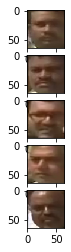

In [221]:
for i in range(5):
    
    plt.subplot(5,1,i+1)
    plt.imshow((trans((face_v[i]).squeeze(0))))

In [220]:
face_v[4].shape

torch.Size([3, 64, 64])